Extracts PCA that explain 95% of the variance for each of the feature vectors, and stacks them for classification.

##Set Up

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle #save features
import shutil #save images
from tqdm import tqdm #progress bar
import re


import cv2
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  39920      0 --:--:-- --:--:-- --:--:-- 40287
OK
2 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gcsfuse is already the newest version (2.3.2).
0 upgraded, 0 newly insta

In [67]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721753570,"nanos":218670267},"severity":"INFO","message":"Start gcsfuse/2.3.2 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721753570,"nanos":220767303},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [68]:
#test mounting
os.listdir(local_path)

['feature_matrices',
 'features',
 'preprocessed-data',
 'raw-data',
 'train_data_preprocessed']

##Specify input & create output directory

In [69]:
#specifiy input image folder
input_path = os.path.join(local_path, 'train_data_preprocessed')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'features')
os.makedirs(output_path, exist_ok=True)

In [70]:
#test makedir
os.listdir(f"{local_path}")

['feature_matrices',
 'features',
 'preprocessed-data',
 'raw-data',
 'train_data_preprocessed']

In [71]:
input_files = os.listdir(input_path)
print("Number of Images: ", len(input_files))
print("Sample file name: ", input_files[0])

Number of Images:  6254
Sample file name:  A01_02260289.JPG


## Helper functions

In [72]:
def load_features(file_path):
    with open(file_path, 'rb') as f:
        features = pickle.load(f)
    return features

In [73]:
def preprocess_features(features):
    # Convert to numpy array
    features_array = np.array(list(features.values()))

    # Standardize
    scaler = StandardScaler()
    features_std = scaler.fit_transform(features_array)

    return features_std

In [74]:
def perform_pca(features, variance=0.95):
    pca = PCA(n_components=variance)
    pca.fit(features)

    features_reduced = pca.transform(features)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    num_components_95 = np.argmin(np.abs(cumulative_explained_variance - variance)) + 1

    return cumulative_explained_variance, features_reduced, num_components_95

In [75]:
def plot_explained_variance(cumulative_explained_variances, feature_names=None, variance=0.95):
    plt.figure(figsize=(10, 6))

    if feature_names is None:
        feature_names = ['Feature']

    num_features = len(cumulative_explained_variances)
    if isinstance(cumulative_explained_variances, np.ndarray):
        cumulative_explained_variances = [cumulative_explained_variances]
        feature_names = [feature_names[0]] * num_features

    for cumulative_explained_variance, feature_name in zip(cumulative_explained_variances, feature_names):
        plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label=feature_name)

        num_components_95 = np.argmin(np.abs(cumulative_explained_variance - variance)) + 1

        # Plot dotted line equivalent to the number of components that explain 95% of the variance
        plt.plot([num_components_95, num_components_95], [0, variance], 'k--')
        plt.text(num_components_95, variance - 0.02*(feature_names.index(feature_name)+1), f'{feature_name}: {num_components_95} components', ha='center', va='bottom')

    plt.legend()
    plt.ylim([0, 1.2])
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.show()


In [76]:
# Show in 2 dimensions:  n_components=2. Code adapted from class excercise
def get_tsne(feature_arrays, n_components=2):
    xtsne_list = []
    for features in feature_arrays:
        tsne = TSNE(n_components=n_components, random_state=0)
        features_tsne = tsne.fit_transform(features)
        xtsne_list.append(features_tsne)
    return xtsne_list

## Load and preprocess features

- The features are all dictionaries with same filename as key, values are flattened arrays of the features.

- train_hog2 -> shape = (14688,)
- train_sobel2 -> shape = (27648,)

In [77]:
model_names = ['hog2', 'sobel2', 'cnn']
feature_arrays = []
feature_names = []

for model_name in model_names:
    file_path = os.path.join(output_path, f"train_{model_name}.pkl")
    if os.path.isfile(file_path):
        features = load_features(file_path)
        features_std = preprocess_features(features)
        feature_arrays.append(features_std)
        feature_names.append(model_name.upper())
    else:
        print(f"No file found at {file_path}")

In [78]:
feature_hog = load_features(output_path+'/train_hog.pkl')
feature_sobel = load_features(output_path+'/train_sobel.pkl')
feature_cnn = load_features(output_path+'/train_cnn.pkl')

In [79]:
# Check that number of images for all feature dictionaries is correct
num_images = len(input_files)
assert(len(feature_hog)==num_images)
assert(len(feature_sobel)==num_images)
assert(len(feature_cnn)==num_images)


## Preprocess feature vectors for PCA

In [80]:
feature_hog_std = preprocess_features(feature_hog)
feature_sobel_std = preprocess_features(feature_sobel)
feature_cnn_std = preprocess_features(feature_cnn)

## PCA

- Retain all components, and those that explain 95% explained variance
- [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

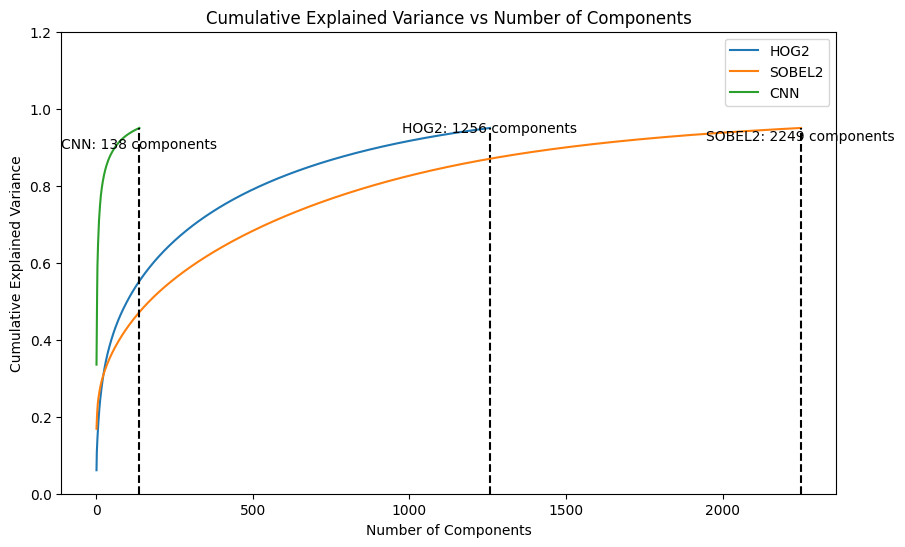

In [81]:
cumulative_explained_variances = []
pca_components = []
num_components = []
for feature_array, feature_name in zip(feature_arrays, feature_names):
    cumulative_explained_variance, feature_reduced, num_components_95 = perform_pca(feature_array)
    cumulative_explained_variances.append(cumulative_explained_variance)
    pca_components.append(feature_reduced)
    num_components.append(num_components_95)

plot_explained_variance(cumulative_explained_variances, feature_names)

# feature vector with components that explain 95% of the variance
final_feature_vector = np.hstack(pca_components)


In [84]:
# vec95 = 138+1256+2249 # length of final feature vector with components that explain 95% variance = 3643
# assert(final_feature_vector.shape[1]==vec95) #for some reason, we get two more features....not sure why!
final_feature_vector.shape

(6254, 3645)

In [86]:
# rename to more meaningful matrix, in order to save
hog_sobel_cnn_pca = final_feature_vector

In [87]:
# Create output directory if it doesn't exist
matrix_path = os.path.join(local_path, 'feature_matrices')
os.makedirs(matrix_path, exist_ok=True)
os.listdir(f"{local_path}")

['feature_matrices',
 'features',
 'preprocessed-data',
 'raw-data',
 'train_data_preprocessed']

In [88]:
# save hog_sobel_cnn_pca as pkl in matrix_path
with open(os.path.join(matrix_path, 'hog_sobel_cnn_pca.pkl'), 'wb') as f:
    pickle.dump(hog_sobel_cnn_pca, f)

## tSNE

In [89]:
tsne_features = get_tsne(feature_arrays)


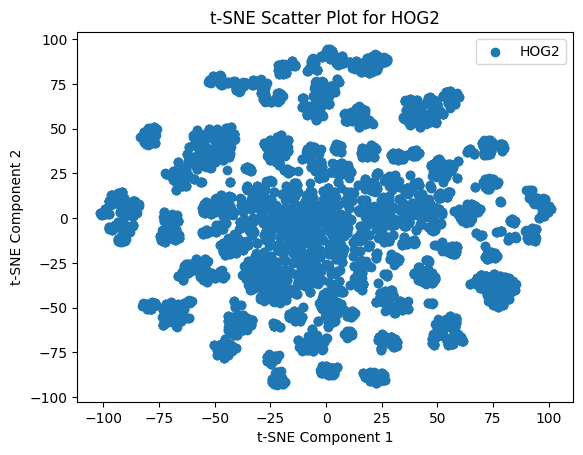

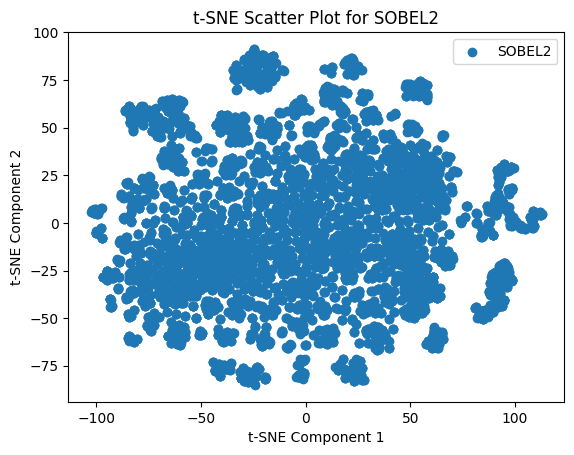

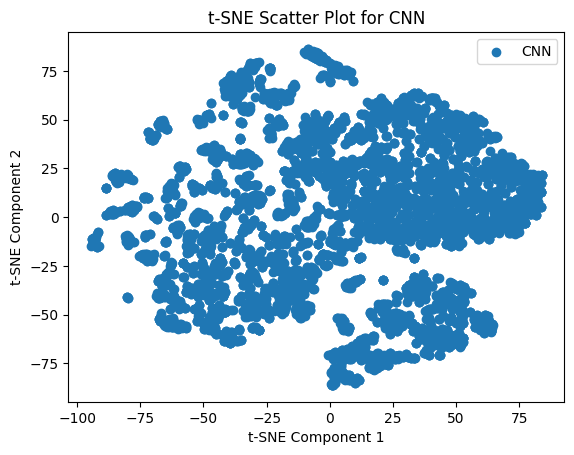

In [90]:
# plot tsne
for i, features in enumerate(tsne_features):
    plt.scatter(features[:, 0], features[:, 1], label=feature_names[i])
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Scatter Plot for {feature_names[i]}')
    plt.legend()
    plt.show()